# Libraries & Functions

In [1]:
'''Math & Data Libraries'''
import numpy as np
import pandas as pd

In [2]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set_style("whitegrid", {"grid.color": "0.5", "axes.edgecolor": "0.2"})
color_palette = ["#FF8853", "#FFE174", "#007597", "#C1C36D", "#00A697", "#BC97E0", "#ffc0bf"] #[ "#007597", "#FF8853", "#C1C36D", "#FFE174","#00A697", "#BC97E0", "#ffc0bf"]
sns.set_palette(sns.color_palette(color_palette))

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

font = {'family': 'serif',
        'color':  '#333333',
        'weight': 'normal',
        'size': 14,
        }

In [5]:
import cmasher as cmr
from matplotlib.colors import ListedColormap
import matplotlib
cmap = cmr.ember #cmr.amber
c = 0.25
n = 100
cmap = ListedColormap((1. - c) * cmap(np.linspace(0., 1., n)) + c * np.ones((n, 4)))

In [25]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))# + [100]


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [63]:
cmap_dict = {}
for i in range(7):
    test_color_rgb = hex_to_rgb(color_palette[i])
    N = 256
    test_color_map = np.ones((N, 4))
    top = 1
    test_color_map[:, 0] = np.linspace(test_color_rgb[0]/256, test_color_rgb[0]/256, N) # R = 255
    test_color_map[:, 1] = np.linspace(test_color_rgb[1]/256, test_color_rgb[1]/256, N) # G = 232
    test_color_map[:, 2] = np.linspace(test_color_rgb[2]/256, test_color_rgb[2]/256, N)  # B = 11
    test_color_map[:, 3] = np.linspace(0.3, 1, N)  # B = 11

    cmap_dict[i] = ListedColormap(test_color_map)

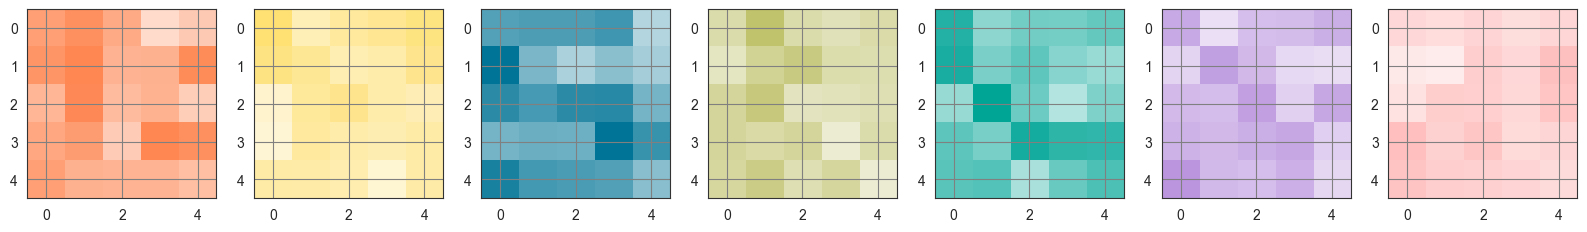

In [64]:
fig, ax = plt.subplots(figsize = (20,4), ncols = 7)
for i in range(0,7):
    ax[i].imshow(np.random.normal(0, 1, (5,5)), cmap = cmap_dict[i])
    # ax[0].colorbar()
plt.show()

In [6]:
def draw_results(dataset, model, focus_name, threshold = 0, cmap = cmap):
    fig, ax = plt.subplots(figsize=(15,7), ncols = 2)
    plt.suptitle(dataset + " " + model + " " + focus_name + " QA Predictions with a Threshold = " + str(threshold))

    score_test = np.array(score_dict[dataset, model, focus_name])[pred_mask_dict[dataset, model, focus_name]]
    
    df = pd.DataFrame()
    df["Data_Orig"] = np.array(true_dict[dataset, model, focus_name])[pred_mask_dict[dataset, model, focus_name]]
    df["Predictions_Orig"] = post_predictions_dict[dataset, model, focus_name][pred_mask_dict[dataset, model, focus_name]]
    df["Score"] = score_test
    df["Above Threshold"] = score_test>=threshold
    df = df[df["Predictions_Orig"]>0]

    scaler = MinMaxScaler()
    scaler.fit(np.log(df["Data_Orig"]).values.reshape(-1, 1))

    df["Data"] = scaler.transform(np.log(df["Data_Orig"]).values.reshape(-1,1))[:, 0]
    df["Predictions"] = scaler.transform(np.log(df["Predictions_Orig"]).values.reshape(-1,1))[:, 0]

    linear_regressor = LinearRegression(fit_intercept = False)
    # linear_regressor = LinearRegression(fit_intercept = True)
    X = df[df["Above Threshold"]==True]["Data"].values.reshape(-1, 1)
    y = df[df["Above Threshold"]==True]["Predictions"].values
    # Fit linear regression model of HDI on the log of CPI
    linear_regressor.fit(X, y)
    x_pred = np.linspace(-10, 10, num=200).reshape(-1, 1)
    y_pred = linear_regressor.predict(x_pred)  
    
    coverage = np.mean(df["Above Threshold"])
    coverage_2 = len(df["Above Threshold"])/500
    r2 = r2_score(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])
    nmae = 100 * mean_absolute_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])/np.average(df[df["Above Threshold"]==True]["Data"])
    nrmse = 100 * mean_squared_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"], squared=False)/np.average(df[df["Above Threshold"]==True]["Data"])
    lr_coef = linear_regressor.coef_[0]

    plt.subplot(1,2,1)
    plt.scatter(x = df[df["Above Threshold"]==True]["Data"], y = df[df["Above Threshold"]==True]["Predictions"], c = df[df["Above Threshold"]==True]["Score"], cmap = cmap, vmin = 0, s = 20, alpha = 0.5)
    # sns.scatterplot(data = df[df["Above Threshold"]==True], x = "Data", y = "Predictions", hue = "Score", palette = cmap, alpha = 0.8)
    plt.plot(np.arange(-10,10),np.arange(-10,10), color = color_palettes["personal_shuffled_3"][2], label="Theoretical Perfect Fit", linewidth = 3, alpha=0.5)
    plt.plot(x_pred,y_pred, color = color_palettes["personal_shuffled_3"][3], label="Regression Line", linewidth = 3, alpha=0.5)
    plt.xlabel("Data")
    plt.ylabel("Predictions")
    plt.xlim(0,1)#np.log(0.005), np.log(120))
    plt.ylim(0,1)#np.log(0.005), np.log(120))
    plt.legend()

    plt.text(0.1, 0.83, "Recall: {} ({})".format(np.round(coverage, 3), np.round(coverage_2, 2)), fontdict=font)
    plt.text(0.1, 0.78, "R2: {}".format(np.round(r2, 3)), fontdict=font)
    plt.text(0.1, 0.73, "nMAE: {} %".format(np.round(nmae, 2)), fontdict=font)
    plt.text(0.1, 0.68, "nRMSE: {} %".format(np.round(nrmse, 2)), fontdict=font)
    plt.text(0.1, 0.63, r'$\beta$: {}'.format(np.round(lr_coef, 2)), fontdict=font)

    plt.subplot(1,2,2)
    sns.kdeplot(data = df[df["Above Threshold"]==True], x = "Data", y = "Predictions", cmap=cmap, fill = True, bw_adjust=1, label = "Kernel Density Estimation")
    plt.plot(np.arange(-10,10),np.arange(-10,10), color = color_palettes["personal_shuffled_3"][2], label="Theoretical Perfect Fit", linewidth = 3)
    plt.plot(x_pred,y_pred, color = color_palettes["personal_shuffled_3"][3], label="Regression Line", linewidth = 3)

    plt.text(0.1, 0.83, "Recall: {} ({})".format(np.round(coverage, 3), np.round(coverage_2, 2)), fontdict=font)
    plt.text(0.1, 0.78, "R2: {}".format(np.round(r2, 3)), fontdict=font)
    plt.text(0.1, 0.73, "nMAE: {} %".format(np.round(nmae, 2)), fontdict=font)
    plt.text(0.1, 0.68, "nRMSE: {} %".format(np.round(nrmse, 2)), fontdict=font)
    plt.text(0.1, 0.63, r'$\beta$: {}'.format(np.round(lr_coef, 2)), fontdict=font)

    plt.xlabel("Data")
    plt.ylabel("Predictions")
    plt.xlim(0,1)#np.log(0.005), np.log(120))
    plt.ylim(0,1)#np.log(0.005), np.log(120))
    plt.legend()

    plt.show()

# Result Data

In [92]:
df_dict = {}
for dataset in ["POWO", "POWO_MGH", "POWO_ML"]:
    df_dict[dataset] = pd.read_excel(f"..//Data//Results//{dataset}_Numerical_Predictions.xlsx")

# Visualizations

In [69]:
def draw_results(df_res, dataset, model, focus_name, focus_code, threshold = 0, cmap = cmap, scatter_color = "black"):
    fig, ax = plt.subplots(figsize=(8,7), ncols = 1)
    plt.suptitle(dataset + " " + model + " " + focus_name + " QA Predictions with a Threshold = " + str(threshold))
    mask = df_res[focus_code].notna()
    N_total = len(df_res)
    df_res = df_res[mask]
    
    pred_mask = (df_res[focus_code + "_" + "Predictions_" + model].notna())*(df_res[focus_code + "_" + "Predictions_" + model]!=-1)#*df_res[focus_code].notna()
    score_test = df_res[focus_code + "_" + "Scores_" + model].values[pred_mask]
    
    df = pd.DataFrame()
    df["Data_Orig"] = df_res[focus_code].values[pred_mask].astype(float)
    df["Predictions_Orig"] = df_res[focus_code + "_" + "Predictions_" + model].values[pred_mask].astype(float)
    df["Score"] = score_test
    df["Above Threshold"] = score_test>=threshold
    df = df[df["Predictions_Orig"]>0]
    
    df["Data_Log"] = np.log(df["Data_Orig"])
    df["Predictions_Log"] = np.log(df["Predictions_Orig"])
    
    scaler = MinMaxScaler()
    df["Data"] = scaler.fit_transform(df["Data_Log"].values.reshape(-1, 1))[:, 0]
    df["Predictions"] = scaler.transform(df["Predictions_Log"].values.reshape(-1,1))[:, 0]
    
    df["Above Threshold"] = df["Above Threshold"]*(df["Predictions"]>=0)*(df["Predictions"]<=1)
    linear_regressor = LinearRegression(fit_intercept = False)
    # linear_regressor = LinearRegression(fit_intercept = True)
    X = df[df["Above Threshold"]==True]["Data"].values.reshape(-1, 1)
    y = df[df["Above Threshold"]==True]["Predictions"].values
    # Fit linear regression model of HDI on the log of CPI
    linear_regressor.fit(X, y)
    x_pred = np.linspace(-10, 10, num=200).reshape(-1, 1)
    y_pred = linear_regressor.predict(x_pred)  
    
    coverage = np.mean(df["Above Threshold"])
    coverage_2 = len(df["Above Threshold"])/N_total
    r2 = r2_score(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])
    nmae = 100 * mean_absolute_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])/np.average(df[df["Above Threshold"]==True]["Data"])
    nrmse = 100 * mean_squared_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"], squared=False)/np.average(df[df["Above Threshold"]==True]["Data"])
    lr_coef = linear_regressor.coef_[0]

    plt.scatter(x = df[df["Above Threshold"]==True]["Data"], y = df[df["Above Threshold"]==True]["Predictions"], c = scatter_color, vmin = 0, s = 25, alpha = 0.2)
    sns.kdeplot(data = df[df["Above Threshold"]==True], x = "Data", y = "Predictions", cmap = cmap, fill = False, levels = [0.05, 0.5, 1], label = "Kernel Density Estimation", linewidths = [1.5, 3])
    plt.plot(np.arange(-10,10),np.arange(-10,10), linestyle = "--", color = "#555555", label="Theoretical Perfect Fit", linewidth = 3, alpha=0.4)
    plt.plot(x_pred, y_pred, linestyle = "-", color = color_palette[1], label="Regression Line", linewidth = 3, alpha=0.7)

    plt.text(0.05, 0.95, "R2: {}".format(np.round(r2, 3)), fontdict=font)
    plt.text(0.05, 0.90, "nMAE: {} %".format(np.round(nmae, 2)), fontdict=font)
    plt.text(0.05, 0.85, "nRMSE: {} %".format(np.round(nrmse, 2)), fontdict=font)
    plt.text(0.05, 0.80, r'$\beta$: {}'.format(np.round(lr_coef, 2)), fontdict=font)
    plt.text(0.05, 0.75, "Recall: {} ({})".format(np.round(coverage, 3), np.round(coverage_2, 2)), fontdict=font)

    plt.xlabel("Data")
    plt.ylabel("Predictions")
    plt.xlim(0,1)#np.log(0.005), np.log(120))
    plt.ylim(0,1)#np.log(0.005), np.log(120))
#     plt.legend()

    plt.show()
    return df

## Plant Height Max

Plant Height Max POWO DistilBERT


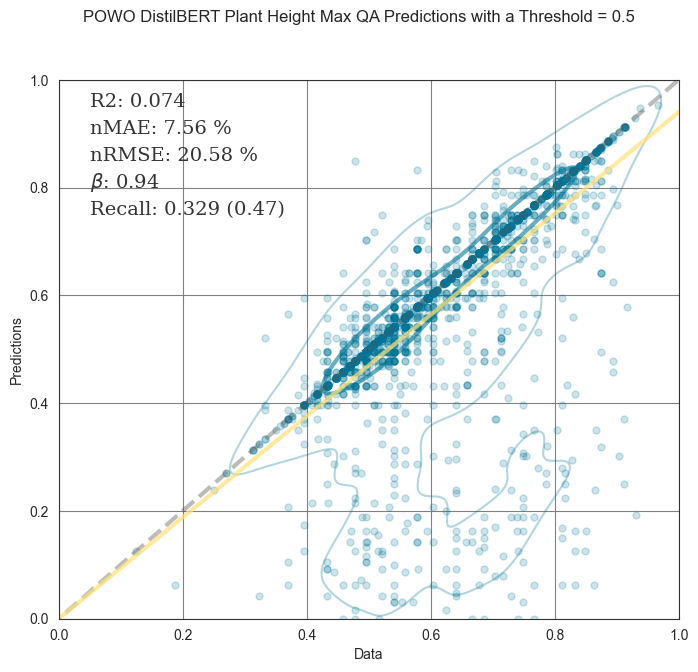

Plant Height Max POWO ROBERTA


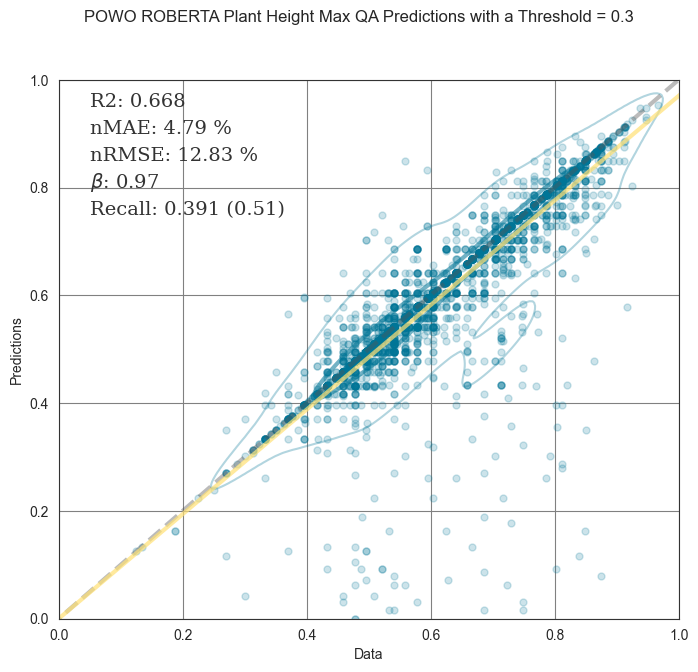

Plant Height Max POWO_MGH DistilBERT


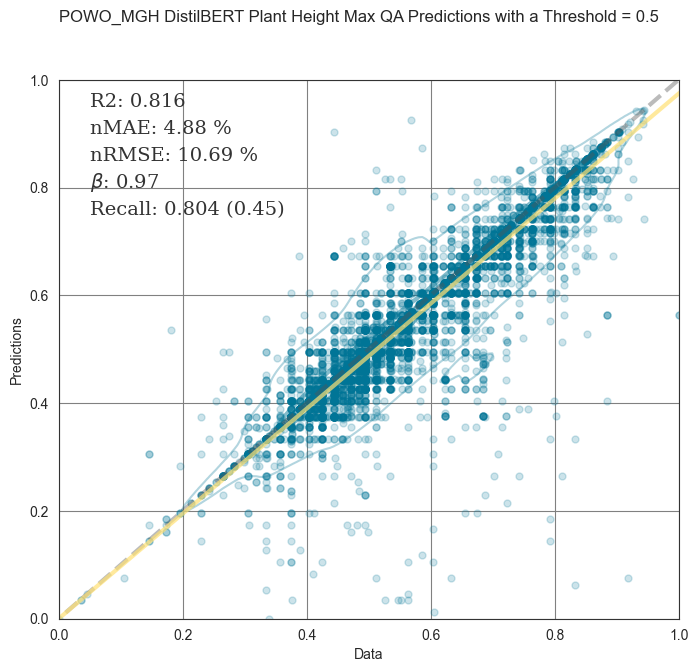

Plant Height Max POWO_MGH ROBERTA


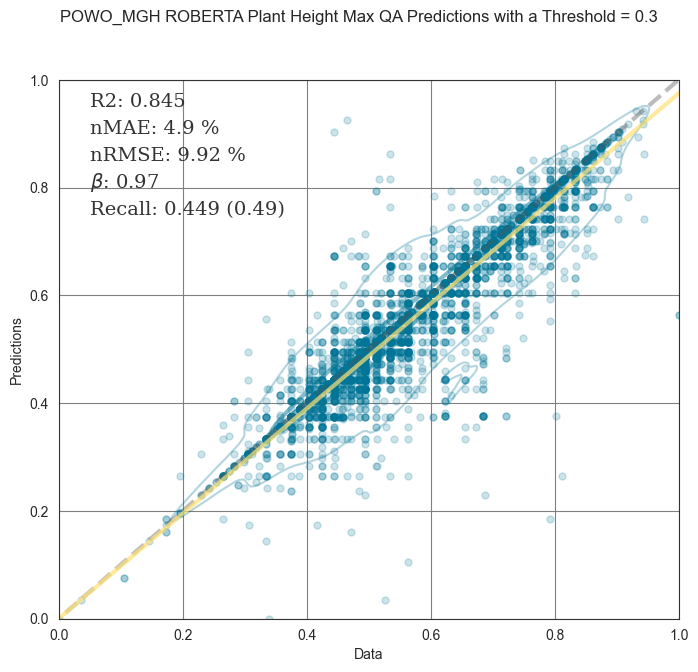

In [60]:
df_res_dict = {}
for focus_name, focus_code in zip(["Plant Height Max"], ["1.6.2"]):
    for dataset in ["POWO", "POWO_MGH"]:
        for model, threshold in zip(["DistilBERT", "ROBERTA"], [0.5, 0.3]): 
            print(focus_name, dataset, model)
            df_test1 = draw_results(df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:], dataset, model, focus_name, focus_code, threshold = threshold, cmap = cmap_dict[2], scatter_color = color_palette[2])

## Leaf Length Max

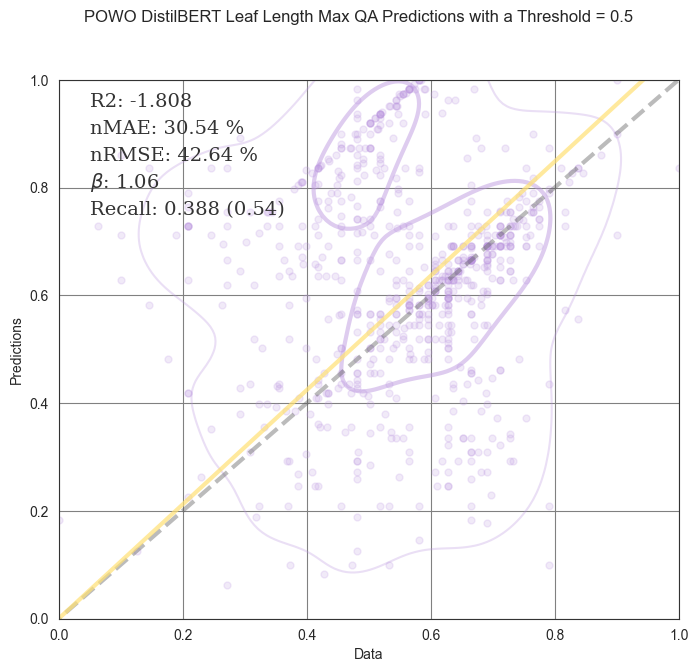

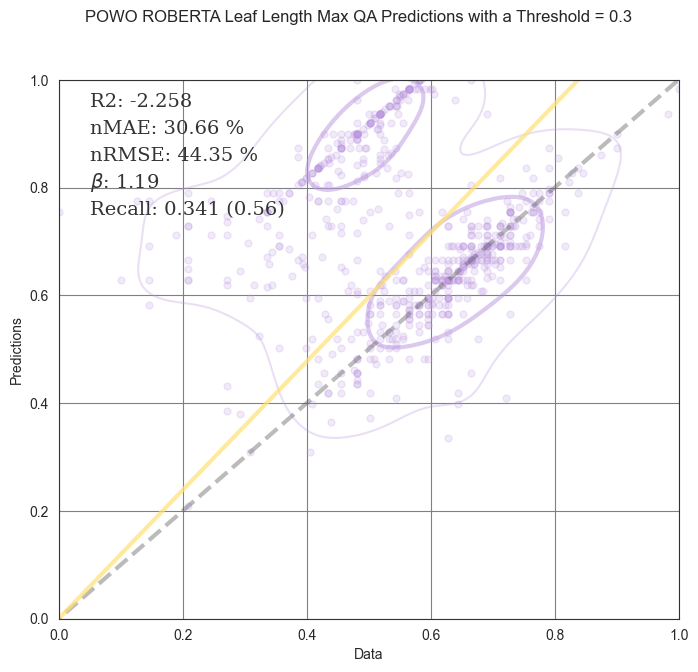

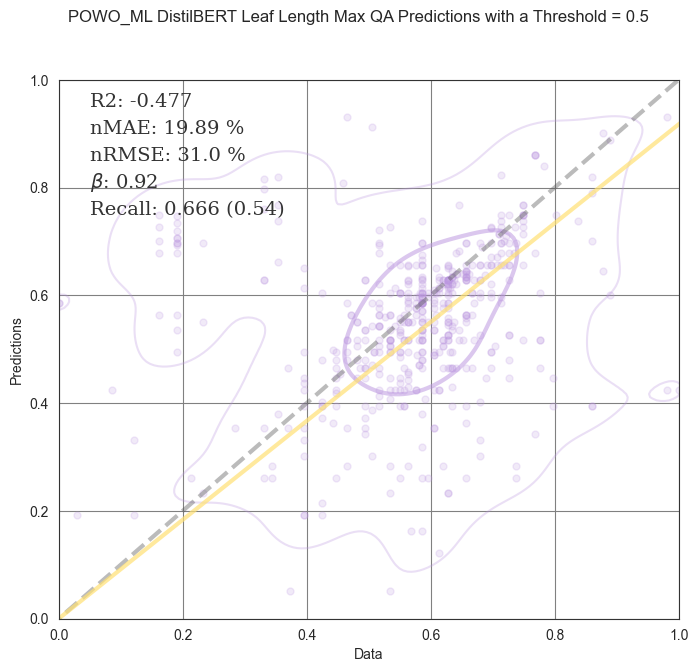

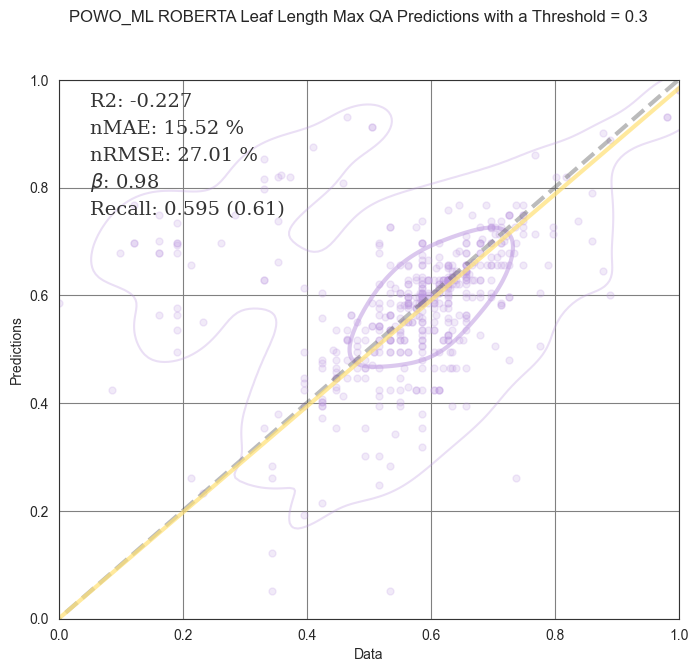

In [93]:
df_res_dict = {}
for focus_name, focus_code in zip(["Leaf Length Max"], ["4.6.2"]):
    for dataset in ["POWO", "POWO_ML"]:
        for model, threshold in zip(["DistilBERT", "ROBERTA"], [0.5, 0.3]): 
            df_test1 = draw_results(df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:], dataset, model, focus_name, focus_code, threshold = threshold, cmap = cmap_dict[5], scatter_color = color_palette[5])

## Leaf Width Max

Leaf Width Max POWO DistilBERT


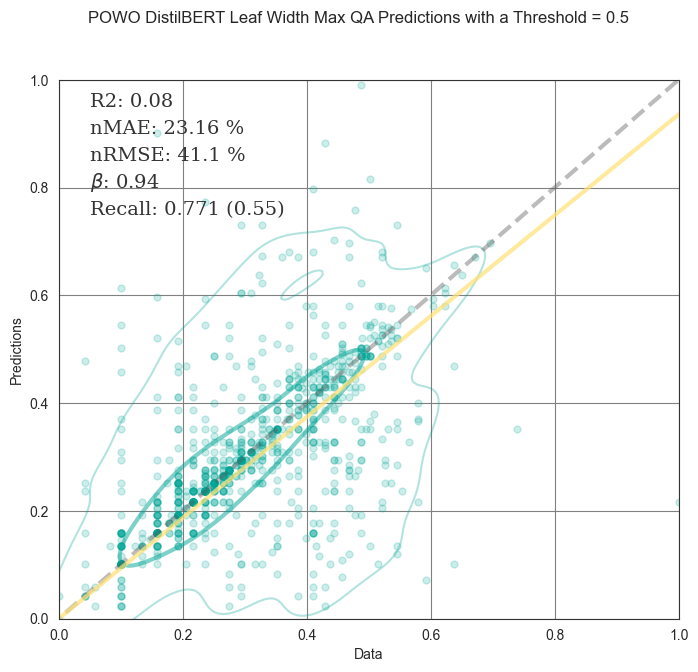

Leaf Width Max POWO ROBERTA


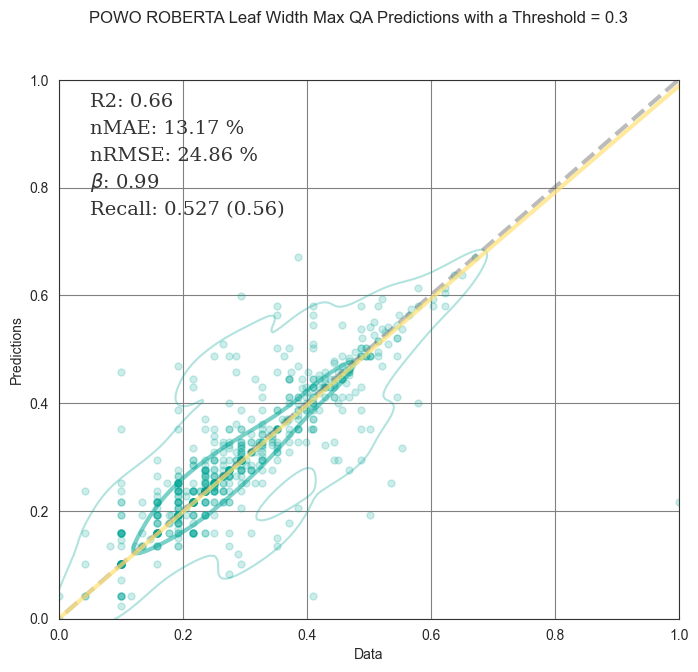

Leaf Width Max POWO_ML DistilBERT


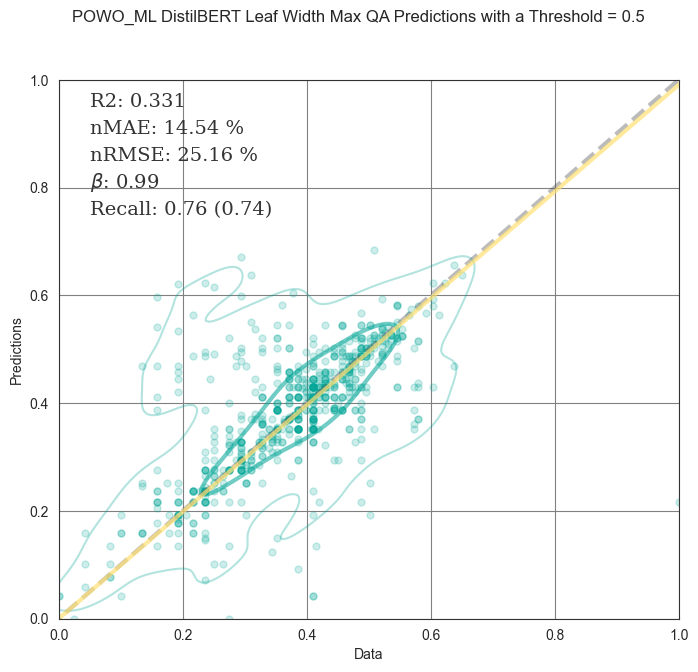

Leaf Width Max POWO_ML ROBERTA


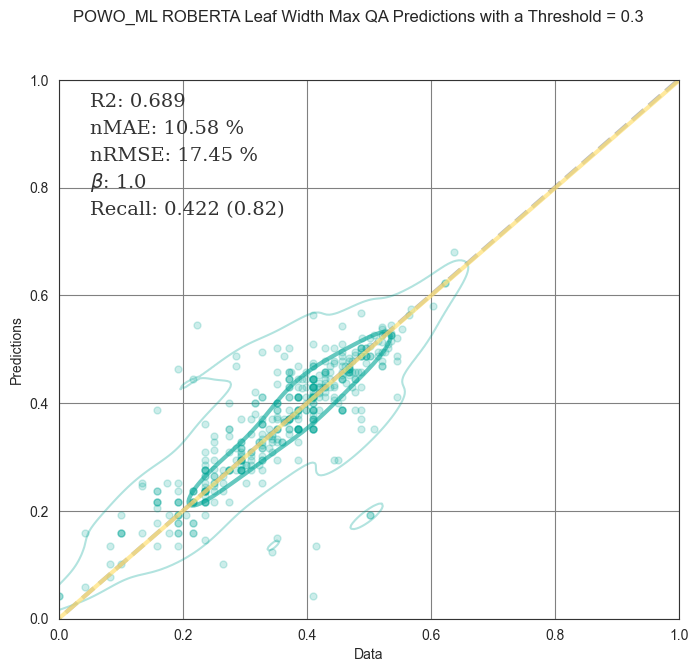

In [90]:
df_res_dict = {}
for focus_name, focus_code in zip(["Leaf Width Max"], ["4.7.2"]):
    for dataset in ["POWO", "POWO_ML"]:
        for model, threshold in zip(["DistilBERT", "ROBERTA"], [0.5, 0.3]): 
            print(focus_name, dataset, model)
            df_test1 = draw_results(df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:], dataset, model, focus_name, focus_code, threshold = threshold, cmap = cmap_dict[4], scatter_color = color_palette[4])